Using TensorFlow backend.


UMPM
Instructions for updating:
Colocations handled automatically by placer.
extract pose with openpose
	elapsed 0.000644683837890625


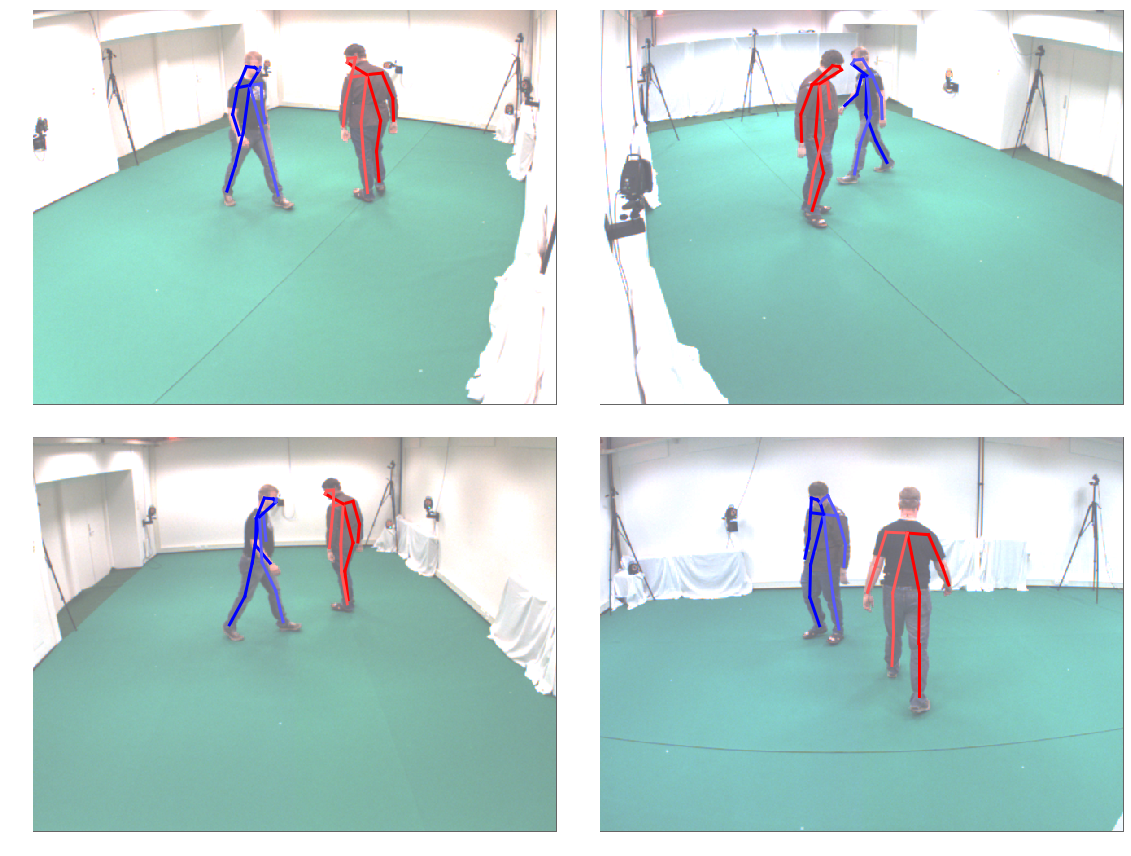

In [1]:
%matplotlib inline
# ---- settings ----

# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '../samples')
sys.path.insert(0, './')
import paf_loader
from os.path import join, isdir
import numpy as np
import cv2
from cselect import color as cs
from time import time
from mvpose import settings

from mvpose.data import umpm

params = settings.get_settings(ms_radius=30)
root = join(Settings['data_root'], 'pak')
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']
tmp = Settings['tmp']

FRAME = 1430
#FRAME = 0
video = 'p2_free_1'

X, Y, Calib = umpm.get(root, video, user, pwd)

Im = np.array([X[0][FRAME], X[1][FRAME], X[2][FRAME], X[3][FRAME]])

# heatmaps, pafs = paf_loader.load_confidence_map_and_paf('umpm', Im, 
#                                                         FRAME, 
#                                                         dir=tmp)

# ====================================
# from poseestimation import model
# pe = model.PoseEstimator()
from openpose import OpenPose

pe = OpenPose(tmp=Settings['tmp'])

print('extract pose with openpose')
_start = time()
positions = pe.predict(Im, 'umpm_' + video, FRAME)
_end = time()
print('\telapsed', _end - _start)
# ====================================

from mvpose.algorithm.candidate_selection import project_human_to_2d
from mvpose.plot.limbs import draw_mscoco_human, draw_mscoco_human2d

# Humans = detections

fig = plt.figure(figsize=(16,12))

colors = ['red', 'blue', 'green']

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2,2,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.6)
    
    for pid, person in enumerate(positions[idx]):
        draw_mscoco_human2d(ax, person[:, 0:2], 
                            color=colors[pid], linewidth=3)
    
plt.tight_layout()
plt.show()

In [ ]:
import cv2
import mvpose.geometry.geometry as gm
from mvpose.geometry.stereo import get_fundamental_matrix

def calculate_cost(cam1, person1, cam2, person2):
    F = get_fundamental_matrix(cam1.P, cam2.P, 0)
    
    # drop all points that are -1 -1 (not visible)
    pts1 = []
    pts2 = []
    weights1 = []
    weights2 = []
    for jid in range(18):
        x1, y1, w1 = person1[jid]
        x2, y2, w2 = person2[jid]
        if x1 >= 0 and x2 >= 0:
            pts1.append((x1, y1))
            weights1.append(w1)
            pts2.append((x2, y2))
            weights2.append(w2)
    weights1 = np.clip(weights1, a_min=0, a_max=1)
    weights2 = np.clip(weights2, a_min=0, a_max=1)
    
    pts1 = np.array(pts1, 'float32')
    pts2 = np.array(pts2, 'float32')
    
    epilines_1to2 = np.squeeze(
        cv2.computeCorrespondEpilines(pts1, 1, F))
    
    epilines_2to1 = np.squeeze(
        cv2.computeCorrespondEpilines(pts2, 2, F))
    
    total = 0
    
    for p1, l1to2, w1, p2, l2to1, w2 in zip(
        pts1, epilines_1to2, weights1,
        pts2, epilines_2to1, weights2):
        d1 = gm.line_to_point_distance(*l1to2, *p2)
        d2 = gm.line_to_point_distance(*l2to1, *p1)
        total += d1 + d2
    return total/len(pts1)  # normalize
    

cid1 = 0
cid2 = 1
cam1 = Calib[cid1]
cam2 = Calib[cid2]
person1 = positions[cid1][1]
person2 = positions[cid2][1]
cost = calculate_cost(cam1, person1, cam2, person2)
print('cost', cost)

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(121)
ax.imshow(Im[cid1], alpha=0.6)
draw_mscoco_human2d(ax, person1[:, 0:2], 'red', linewidth=3)

ax = fig.add_subplot(122)
ax.imshow(Im[cid2], alpha=0.6)
draw_mscoco_human2d(ax, person2[:, 0:2], 'red', linewidth=3)

plt.show()

In [ ]:
# # Triangulate

# cid1 = 0
# cid2 = 1
# cam1 = Calib[cid1]
# cam2 = Calib[cid2]
# P1 = cam1.P
# P2 = cam2.P
# person1 = positions[cid1][1]
# person2 = positions[cid2][1]
# cost = calculate_cost(cam1, person1, cam2, person2)

# nose1 = person1[0]
# nose2 = person2[0]

# Pt1 = np.transpose(np.array([nose1[0:2]]))
# Pt2 = np.transpose(np.array([nose2[0:2]]))

# # --- lsq
# u1, v1 = nose1[0:2]
# u2, v2 = nose2[0:2]
# y = np.array([u1, v1, 1, u2, v2, 1])
# H = np.concatenate([P1, P2], axis=0)

# _x, _y, _z, _h = la.pinv(H) @ y
# X = [_x/_h, _y/_h, _z/_h]

# print("X", X)

# # --- lsq end


# pt3d = np.squeeze(gm.from_homogeneous(
#     np.transpose(cv2.triangulatePoints(P1, P2, Pt1, Pt2))))
# print("true 3d point", pt3d)
# pt2d_1 = np.squeeze(cam1.projectPoints(np.array([pt3d])))
# pt2d_2 = np.squeeze(cam2.projectPoints(np.array([pt3d])))

# ptX2d_1 = np.squeeze(cam1.projectPoints(np.array([X])))
# ptX2d_2 = np.squeeze(cam2.projectPoints(np.array([X])))


# # ---

# fig = plt.figure(figsize=(16, 12))
# ax = fig.add_subplot(121)
# ax.imshow(Im[cid1], alpha=0.6)
# ax.scatter(*nose1[0:2], color='red', s=100, alpha=0.5)
# ax.scatter(*pt2d_1, color='green', s=50)
# ax.scatter(*ptX2d_1, color='blue', s=50)

# ax = fig.add_subplot(122)
# ax.imshow(Im[cid2], alpha=0.6)
# ax.scatter(*nose2[0:2], color='red', s=100, alpha=0.5)
# ax.scatter(*pt2d_2, color='green', s=50)
# ax.scatter(*ptX2d_2, color='blue', s=50)

# plt.show()

In [ ]:
# human

In [ ]:
from mvpose.baseline.baseline import estimate

H = estimate(Calib, positions)

fig = plt.figure(figsize=(16,12))

colors = ['red', 'blue', 'green']

for cid, cam in enumerate(Calib):
    ax = fig.add_subplot(2,2,1+cid)
    ax.set_xlim([0, 644])
    ax.set_ylim([486, 0])
    ax.axis('off')
    im = Im[cid]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.6)
    
    for pid, hyp in enumerate(H):
        
        # find the right cid...
        redirect_cid = -1
        for cid2, _cam in enumerate(hyp.cams):
            if _cam.cid == cid:
                redirect_cid = cid2
                break
        
        if redirect_cid >= 0:
            points = hyp.points[redirect_cid]
            ax.scatter(points[:,0], points[:,1], color=colors[pid],
                      alpha=0.5)

        human = hyp.get_3d_person()
        draw_mscoco_human(ax, human, cam, alpha=0.5,
                          color=colors[pid], linewidth=3)
    
plt.tight_layout()
plt.show()

In [ ]:

import numpy.linalg as la

P1 = np.array([
    [1, 0, 0],
    [0, 1, 0]
])

P2 = np.array([
    [1, 0, 0],
    [0, 0, 1]
])

X = np.array([1, 2, 3])


x1 = P1 @ X
x2 = P2 @ X

H = np.concatenate([P1, P2], axis=0)

H @ X

In [ ]:
y = np.concatenate([x1, x2], axis=0)


X_hat = la.pinv(H) @ y

X_hat